In [2]:
import sys
sys.path.insert(1, '../src')

Importing necessary packages to visualize the library's figures. 

In [3]:
import LLM_MRI
import matplotlib.pyplot as plt
from datasets import load_dataset, features, ClassLabel
import networkx as nx

2024-07-11 13:19:07.532282: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-11 13:19:07.563504: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 13:19:08.050161: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading Emotions Dataset from Hugging Face hub

In [4]:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
emotions = load_dataset("csv", data_files=dataset_url, sep=";", 
                               names=["text", "label"], split='train[:3%]')

As the "Emotions" Dataset did not contain the "label" category, it is necessary to get the labels and turn into 'ClassLabel' type.

In [5]:
label_feature = emotions.features["label"]

class_names  = emotions.unique("label")
class_feature = features.ClassLabel(names=sorted(class_names))
emotions = emotions.map(lambda str_value: {"label": class_feature.str2int(str_value)}, input_columns="label")

emotions = emotions.cast(features.Features({
    "label": class_feature,
    "text": emotions.features["text"]}))


In [6]:
model_ckpt = "distilbert-base-uncased"

In [7]:
llm_mri = LLM_MRI(model=model_ckpt, device="cpu", dataset=emotions)

## Proccess Areas

When the user provides a model and a corpus for activation analysis, the _process_activation_areas_ function extracts all hidden states from the model, enabling the user to visualize them as tensors.

In [8]:
llm_mri.process_activation_areas(map_dimension = 10)

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

## Layer Image

The _get_layer_image_ function allows the user to visualize activations in neuron regions produced by the model's dimensionality reduction. Each cell represents a different region in a specified layer provided by the user. By passing a category as a parameter, the function enables visualization of the activations in the specified layer for the given category.

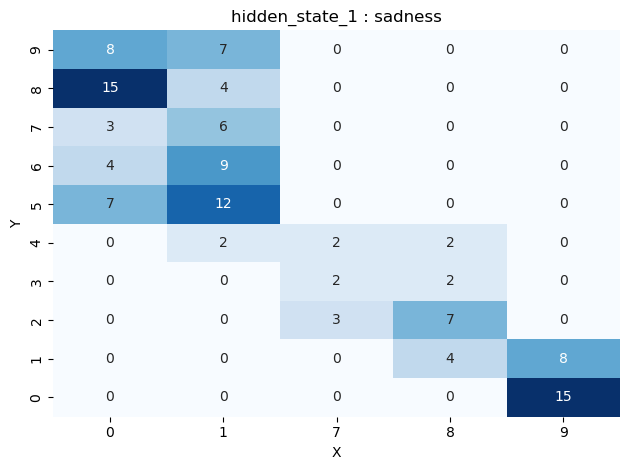

In [9]:
fig = llm_mri.get_layer_image(layer=1, category="sadness")
plt.tight_layout()
plt.show()

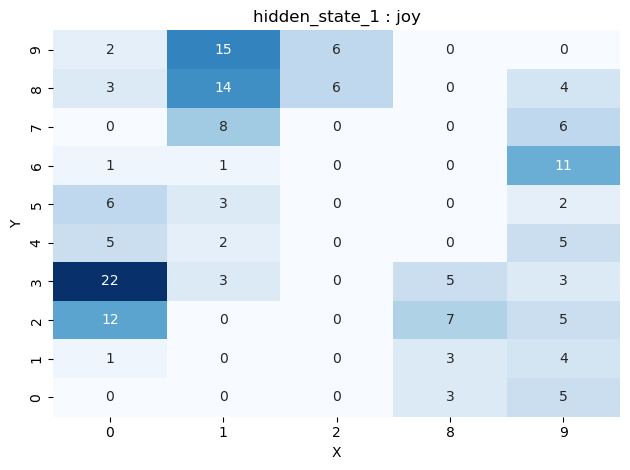

In [10]:
fig = llm_mri.get_layer_image(layer=1, category="joy")
plt.tight_layout()
plt.show()

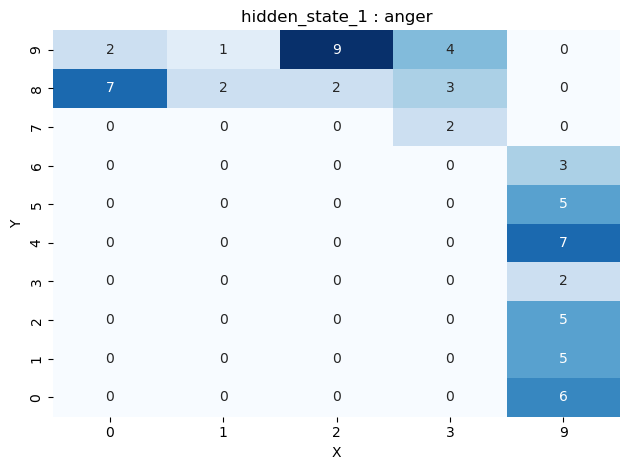

In [11]:
fig = llm_mri.get_layer_image(layer=1, category="anger")
plt.tight_layout()
plt.show()

Here, we can observe how activations in the first hidden layer compare among the categories of sadness, joy, and anger. It is evident that "sadness" predominantly activated regions in the top left and bottom right of the grid, while joy's activations were more evenly distributed across the grid. Additionally, for the "anger" label, the activations were concentrated mainly at X = 9 and Y = 9.

From this observation, we can infere that certain regions, such as (0, 9), could be more likely to be associated with "negative" feelings. This is because a significant percentage of documents labeled as "sadness" and "anger" activated this specific region, while only a few labeled as "joy" did.

## Graph visualization

The _get_graph()_ function enables the user to obtain a Networkx graph representing the neuron activations in the hidden states. Each set of nodes represents activations in a specific hidden layer, while the edges between nodes indicate that documents with the specified label activated both regions.

The _get_graph_image()_ function generates an image of the graph, allowing it to be visualized by the user.

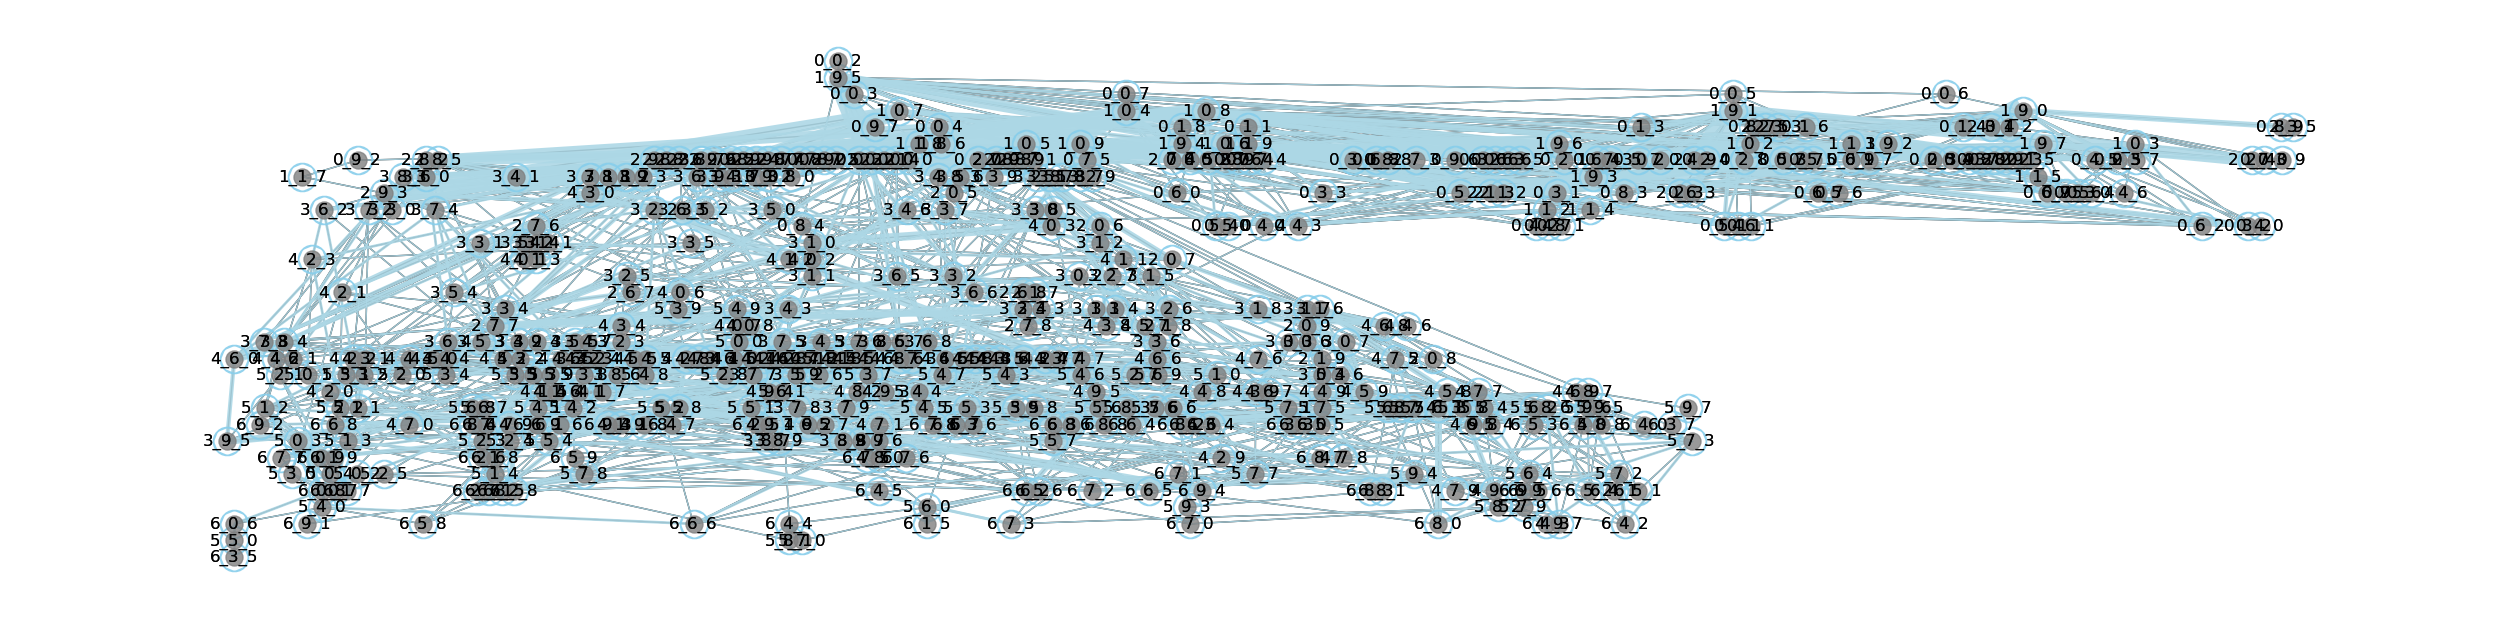

In [12]:
g = llm_mri.get_graph()

g_img = llm_mri.get_graph_image(g)
plt.box(False)
plt.show()

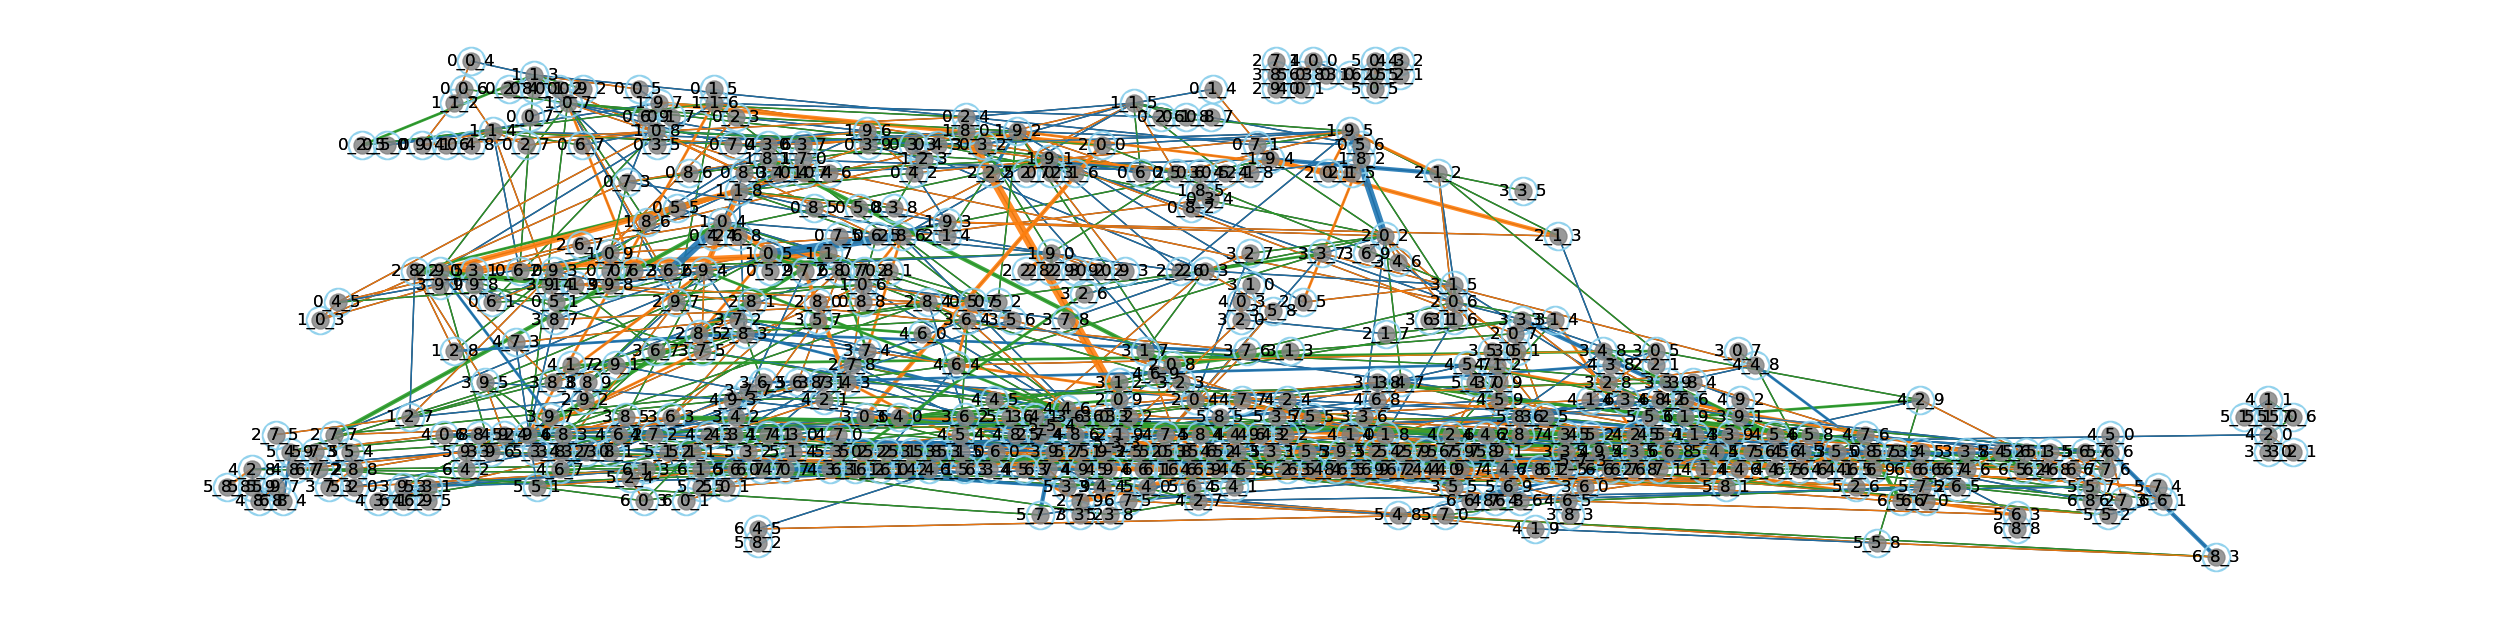

In [13]:
g_false = llm_mri.get_graph(category_name="sadness")
g_true = llm_mri.get_graph(category_name="anger")
g_composed = nx.compose(g_true, g_false)

duplicates = list(set(g_true.edges) & set(g_false.edges))
for e in duplicates : g_composed.edges[e]['label'] = 2 


g_composed_img = llm_mri.get_graph_image(g_composed)
plt.box(False)
plt.show()